In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as sms

In [2]:
def formatter_pvalue(x):
  return "color: red" if x < 0.05 else None

def formatter_one_zero(x):
  return "Tidak Ada" if x == 0 else "Ada"

def plot_corr(df):
  df_corr = df.corr(numeric_only=True)
  mask = np.triu(np.ones_like(df_corr, dtype=bool))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  fig, ax = plt.subplots(figsize=(10, 6))
  sns.heatmap(df_corr, ax=ax, annot=True, fmt=".2f", mask=mask, cmap=cmap, center=0)
  plt.show()

def plot_dist(df, col):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

  sns.histplot(data=df, x=col, kde=True, ax=ax1)
  ax1.set_title("Distributions")

  sm.qqplot(df[col], line="s", ax=ax2)
  ax2.set_title("QQ Plot")

  fig.tight_layout()
  plt.show()

def outlier_stats(dfo):
  total_data = dfo.shape[0]
  outliers_count = (dfo["is_outlier"] == True).sum()
  outliers_percent = outliers_count / total_data

  print("Total data:", total_data)
  print("Outliers count: {0:.2f} ({1:.2%})".format(outliers_count, outliers_percent))

def pointbiser_corr(dfp: pd.DataFrame, prefix: str) -> pd.DataFrame:
    cols = [x for x in dfp.columns if prefix in x]
    corrs = []
    for tag in cols:
        corr = stats.pointbiserialr(dfp[tag], dfp["price"])
        corrs.append({"variable": tag, "method": "pointbiser", "r": corr[0], "pvalue": corr[1]})

    return pd.DataFrame(corrs)

def pearsonr_corr(dfp: pd.DataFrame) -> pd.DataFrame:
    cols = [x for x in dfp.select_dtypes(include="number").columns if x != "price"]
    corrs = []
    for tag in cols:
        corr = stats.pearsonr(dfp[tag], dfp["price"])
        corrs.append({"variable": tag, "method": "pearson", "r": corr[0], "pvalue": corr[1]})

    return pd.DataFrame(corrs)

In [3]:
df_houses = pd.read_parquet("../dataset/etl/L1.houses.parquet") # DONE
df_tags = pd.read_parquet("../dataset/etl/L1.house_tags.parquet") # DONE
df_specs = pd.read_parquet("../dataset/etl/L1.house_specs.parquet") # DONE
df_material = pd.read_parquet("../dataset/etl/L1.house_material.parquet") # DONE
df_facilities = pd.read_parquet("../dataset/etl/L1.house_facilities.parquet") # DONE
df_agent_company = pd.read_parquet("../dataset/etl/L1.house_agent_company.parquet") # DONE
df_floor_material = pd.read_parquet("../dataset/etl/L1.house_floor_material.parquet") # DONE

## L1: Houses

In [4]:
df_houses["district"] = df_houses["address"].str.split(",").str[0]
df_houses["last_modified_at"] = pd.to_datetime(df_houses["last_modified_at"])
df_houses = df_houses.drop(columns=["address", "description", "url", "scraped_at"])

df_houses.head()

,id,price,installment,last_modified_at,district
0,hos7134669,3300.0,14.0,2024-01-18,Puncak
1,hos7134732,850.0,3.0,2023-09-12,Cipanas
2,hos7134830,1000.0,4.0,2023-08-14,Cileungsi
3,hos7135635,2500.0,11.0,2023-09-24,Caringin
4,hos7136060,3000.0,13.0,2023-11-29,Kranggan


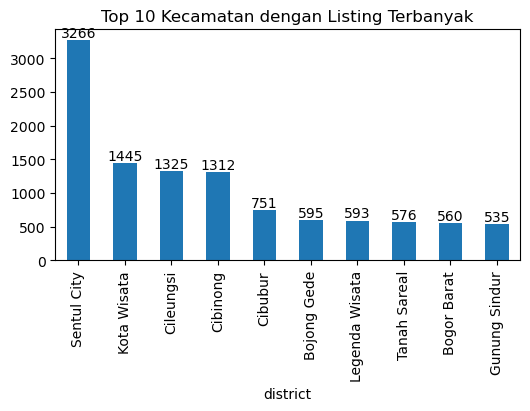

In [5]:
kecamatan_ax = df_houses["district"].value_counts().head(10).plot.bar(figsize=(6, 3))
kecamatan_ax.bar_label(kecamatan_ax.containers[0])
plt.title("Top 10 Kecamatan dengan Listing Terbanyak")
plt.show()

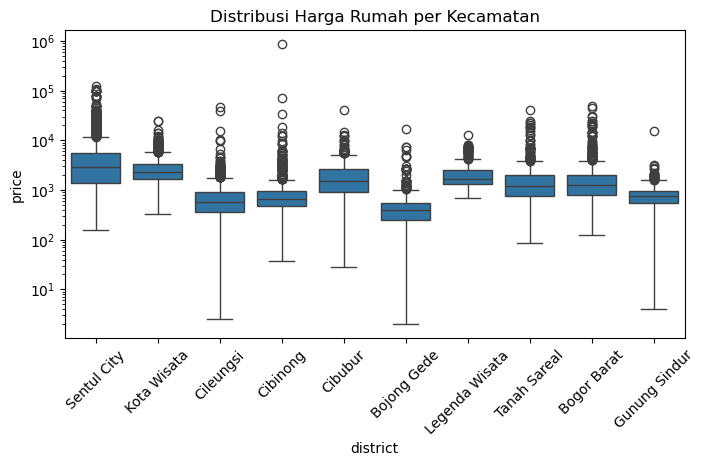

In [6]:
district_top10 = df_houses["district"].value_counts().head(10).index
df_district_price = df_houses[df_houses["district"].isin(district_top10)]

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_district_price, x="district", y="price", order=district_top10)
plt.xticks(rotation=45)
plt.yscale("log")
plt.title("Distribusi Harga Rumah per Kecamatan")
plt.show()

In [7]:
df_houses["date"] = df_houses["last_modified_at"].dt.date
df_houses.head()

,id,price,installment,last_modified_at,district,date
0,hos7134669,3300.0,14.0,2024-01-18,Puncak,2024-01-18
1,hos7134732,850.0,3.0,2023-09-12,Cipanas,2023-09-12
2,hos7134830,1000.0,4.0,2023-08-14,Cileungsi,2023-08-14
3,hos7135635,2500.0,11.0,2023-09-24,Caringin,2023-09-24
4,hos7136060,3000.0,13.0,2023-11-29,Kranggan,2023-11-29


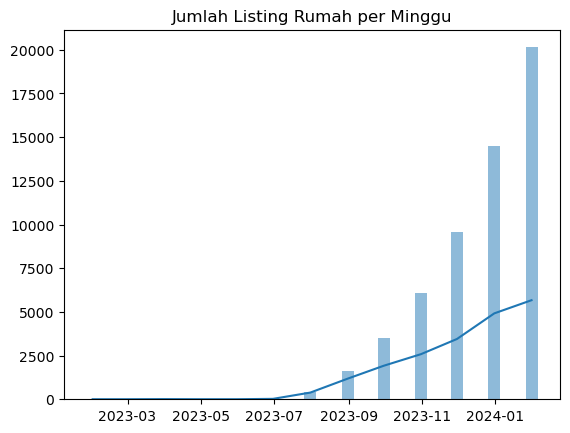

In [8]:
df_houses_ts = df_houses.copy().set_index("last_modified_at").resample("M").count()[["id"]].reset_index().rename(columns={"id": "count"})
df_houses_ts = df_houses_ts[df_houses_ts["count"] > 1]
df_houses_ts["cumulative"] = df_houses_ts["count"].cumsum()

fig, ax1 = plt.subplots()
ax1.plot(df_houses_ts["last_modified_at"], df_houses_ts["count"])
ax1.bar(df_houses_ts["last_modified_at"], df_houses_ts["cumulative"], alpha=0.5, width=10)

plt.title("Jumlah Listing Rumah per Minggu")
plt.show()

In [9]:
df_price = df_houses.pivot_table(index="district", values="price", aggfunc=["count", "mean", "median", "std", "min", "max"], fill_value=0)
df_price.sort_values(("mean", "price"), ascending=False)

,count,mean,median,std,min,max
,price,price,price,price,price,price
district,,,,,,
Cimande,4,30750.000000,38000.0,14500.000000,9000.0,38000.0
Cijayanti,6,24558.166667,2349.5,54149.033603,600.0,135000.0
Cibuluh,15,12313.000000,1900.0,38133.177989,595.0,150000.0
Klapanunggal,28,10938.214286,295.5,45108.276292,58.0,239000.0
Harjasari,3,10533.333333,12500.0,8130.395644,1600.0,17500.0
...,...,...,...,...,...,...
Sukamaju,8,351.875000,345.0,70.047815,245.0,465.0
Pasirlaja,1,330.000000,330.0,NaN,330.0,330.0


### Outlier Analysis

In [10]:
df_houses["price"] = df_houses["price"].fillna(df_houses["price"].median())
df_houses.head()

,id,price,installment,last_modified_at,district,date
0,hos7134669,3300.0,14.0,2024-01-18,Puncak,2024-01-18
1,hos7134732,850.0,3.0,2023-09-12,Cipanas,2023-09-12
2,hos7134830,1000.0,4.0,2023-08-14,Cileungsi,2023-08-14
3,hos7135635,2500.0,11.0,2023-09-24,Caringin,2023-09-24
4,hos7136060,3000.0,13.0,2023-11-29,Kranggan,2023-11-29


In [11]:
Q1 = df_houses['price'].quantile(0.25)
Q3 = df_houses['price'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
df_houses["is_outlier"] = (df_houses['price'] < Q1 - threshold * IQR) | (df_houses['price'] > Q3 + threshold * IQR)

print(outlier_stats(df_houses))
df_houses.head(2)

Total data: 20146
Outliers count: 1901.00 (9.44%)
None


,id,price,installment,last_modified_at,district,date,is_outlier
0,hos7134669,3300.0,14.0,2024-01-18,Puncak,2024-01-18,False
1,hos7134732,850.0,3.0,2023-09-12,Cipanas,2023-09-12,False


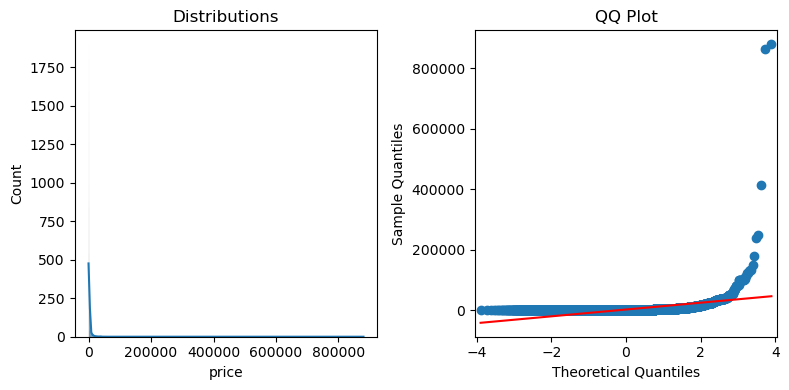

In [12]:
plot_dist(df_houses, "price")

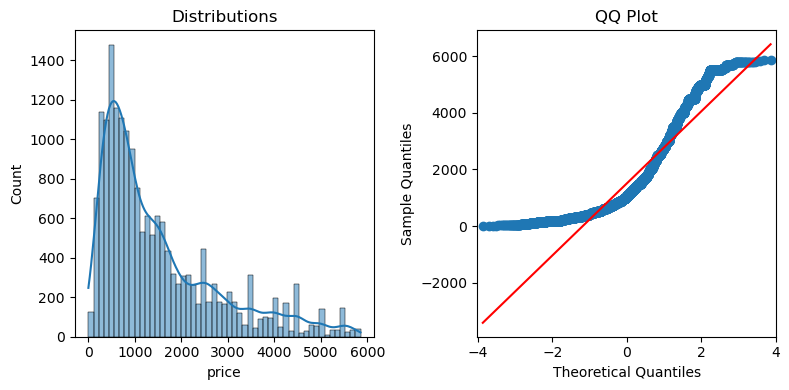

In [13]:
df_oulier_iqr_vis = df_houses[df_houses["is_outlier"] == False]
plot_dist(df_oulier_iqr_vis, "price")

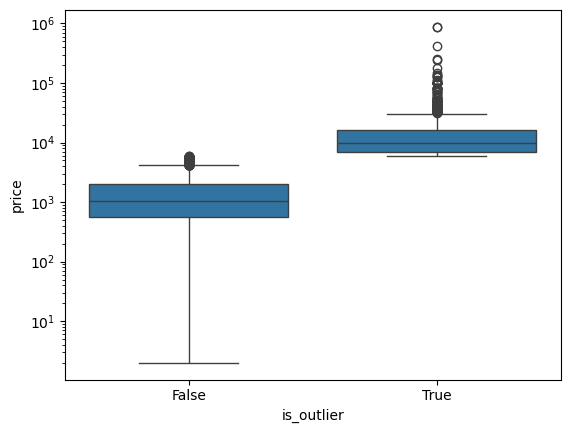

In [14]:
sns.boxplot(data=df_houses, y="price", x="is_outlier")
plt.yscale("log")

In [15]:
# remove outliers
df_houses = df_houses[df_houses["is_outlier"] == False].drop(columns="is_outlier")

## L1: Tags

In [16]:
df_tags.head()

,tag,reference_id
0,bisa_nego,hos7134732
1,one_gate_system,hos7134732
2,bisa_nego,hos7253604
3,bisa_nego,hos7062653
4,cash_keras,hos7062653


In [17]:
df_tags["tag"].unique()

array(['bisa_nego', 'one_gate_system', 'cash_keras', 'kpr', 'perumahan',
       'komplek', 'cash_bertahap', 'pinggir_jalan', 'dijual_cepat',
       'masuk_gang', 'pedesaan'], dtype=object)

In [18]:
df_tags_wide = pd.crosstab(df_tags["reference_id"], df_tags["tag"]).reset_index().add_prefix("tag_")
df_tags_wide = df_houses.merge(df_tags_wide, left_on="id", right_on="tag_reference_id", how="left")
df_tags_wide = df_tags_wide.drop(columns=["tag_reference_id", "id", "last_modified_at"])
df_tags_wide = df_tags_wide.fillna(0)
df_tags_wide.head()

,price,installment,district,date,tag_bisa_nego,tag_cash_bertahap,tag_cash_keras,tag_dijual_cepat,tag_komplek,tag_kpr,tag_masuk_gang,tag_one_gate_system,tag_pedesaan,tag_perumahan,tag_pinggir_jalan
0,3300.0,14.0,Puncak,2024-01-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,850.0,3.0,Cipanas,2023-09-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1000.0,4.0,Cileungsi,2023-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2500.0,11.0,Caringin,2023-09-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3000.0,13.0,Kranggan,2023-11-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


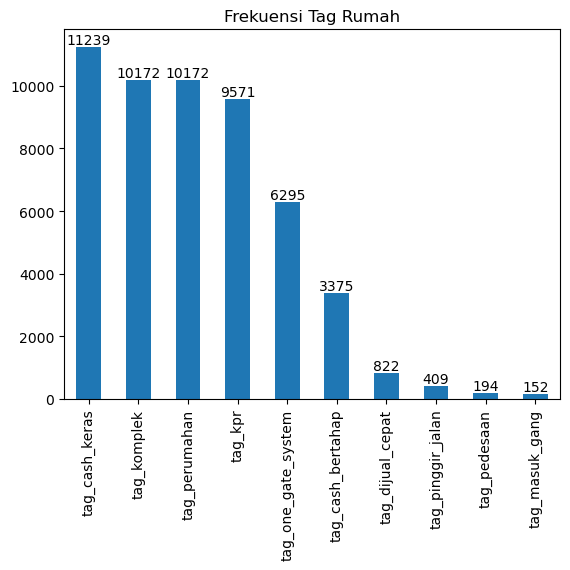

In [19]:
tags_ax = df_tags_wide.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
tags_ax.bar_label(tags_ax.containers[0])

plt.title("Frekuensi Tag Rumah")
plt.show()

In [20]:
piv_tags = df_tags_wide.pivot_table(index="district", columns="tag_bisa_nego", values="price", aggfunc=["mean", "median", "count"], fill_value=0)
piv_tags.sort_values(("mean", 0), ascending=False).round(2)

mean           median         count    
tag_bisa_nego      0.0      1.0     0.0     1.0   0.0 1.0
district                                                 
Babakan Pasar  4000.00  2750.00  4000.0  2750.0     1   2
Lawanggintung  3973.33     0.00  5820.0     0.0     3   0
Gadog          3828.57  3883.33  4000.0  4000.0    14  27
Megamendung    3411.69  3687.71  3850.0  4075.0    29  48
Pabaton        3370.00  3887.78  3500.0  4900.0     5   9
...                ...      ...     ...     ...   ...  ..
Pasir Muncang     0.00  4500.00     0.0  4500.0     0   1
Sukajaya          0.00  2500.00     0.0  2500.0     0   1
Pasirlaja         0.00   330.00     0.0   330.0     0   1
Cipayung          0.00  1444.25     0.0   510.5     0   8
Jl Dr Semeru      0.00  1037.50     0.0  1037.5     0   2

[142 rows x 6 columns]

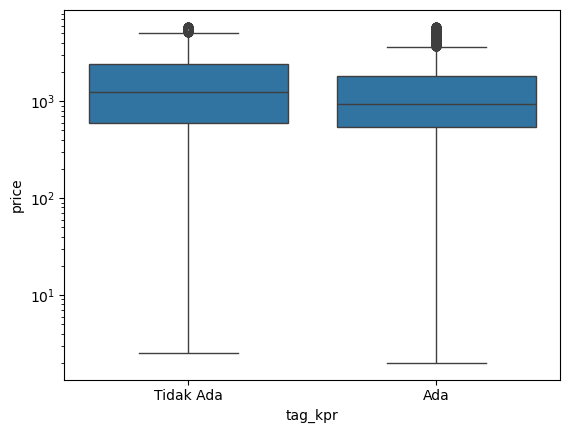

In [21]:
sns.boxplot(data=df_tags_wide, x="tag_kpr", y="price", formatter=formatter_one_zero)
plt.yscale("log")

In [22]:
pointbiser_corr(df_tags_wide, "tag").round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,tag_bisa_nego,pointbiser,-0.014700,0.047100
1,tag_cash_bertahap,pointbiser,-0.236700,0.000000
2,tag_cash_keras,pointbiser,-0.146600,0.000000
3,tag_dijual_cepat,pointbiser,0.016800,0.023100
4,tag_komplek,pointbiser,-0.072500,0.000000
5,tag_kpr,pointbiser,-0.106200,0.000000
6,tag_masuk_gang,pointbiser,-0.053700,0.000000
7,tag_one_gate_system,pointbiser,-0.055200,0.000000
8,tag_pedesaan,pointbiser,-0.005800,0.436500
9,tag_perumahan,pointbiser,-0.072500,0.000000


## L1: Facilities

In [23]:
df_facilities.head()

,reference_id,facility
0,hos7134732,jalur_telepon
1,hos7134732,kolam_ikan
2,hos7134732,taman
3,hos7134732,laundry
4,hos7134732,parkir


In [24]:
df_facilities["facility"].unique()

array(['jalur_telepon', 'kolam_ikan', 'taman', 'laundry', 'parkir', None,
       'keamanan', 'masjid', 'one_gate_system', 'playground', 'dapur',
       'lapangan', 'carport', 'kolam_renang', 'ac', 'water_heater',
       'wastafel', 'mezzanine', 'air_pam', 'garasi', 'gas',
       'lemari_pakaian', 'lemari_sepatu', 'gym', 'canopy', 'halaman',
       'air_tanah', 'balcony', 'shed', 'internet', 'dishwasher',
       'heating', 'water_tank', 'floorboards', 'musholla', 'aula'],
      dtype=object)

In [25]:
df_facilities_wide = pd.crosstab(df_facilities["reference_id"], df_facilities["facility"]).reset_index().add_prefix("fac_")
df_facilities_wide = df_houses.merge(df_facilities_wide, left_on="id", right_on="fac_reference_id", how="left")
df_facilities_wide = df_facilities_wide.drop(columns=["fac_reference_id", "id", "last_modified_at"])
df_facilities_wide = df_facilities_wide.fillna(0)
df_facilities_wide.head()

,price,installment,district,date,fac_ac,fac_air_pam,fac_air_tanah,fac_aula,fac_balcony,fac_canopy,...,fac_mezzanine,fac_musholla,fac_one_gate_system,fac_parkir,fac_playground,fac_shed,fac_taman,fac_wastafel,fac_water_heater,fac_water_tank
0,3300.0,14.0,Puncak,2024-01-18,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,850.0,3.0,Cipanas,2023-09-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1000.0,4.0,Cileungsi,2023-08-14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2500.0,11.0,Caringin,2023-09-24,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3000.0,13.0,Kranggan,2023-11-29,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


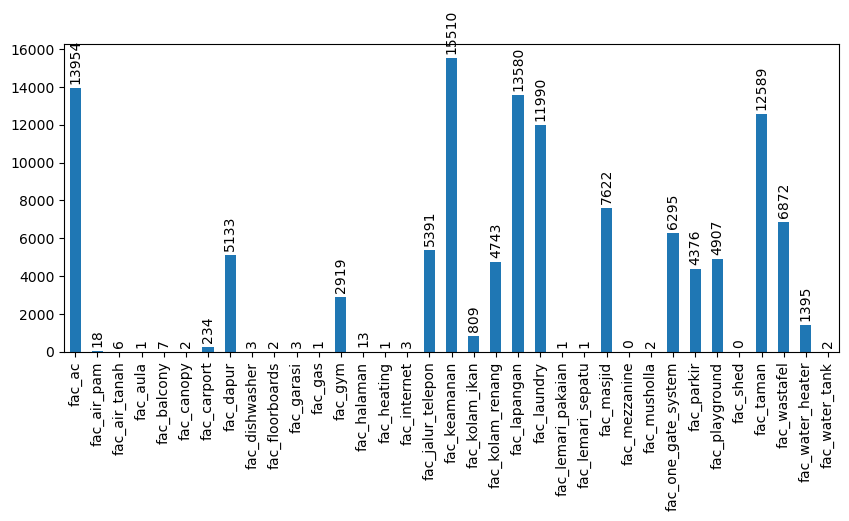

In [59]:
plt.figure(figsize=(10, 4))
fac_count_ax = df_facilities_wide.iloc[:, 4:].sum().plot.bar()
fac_count_ax.bar_label(fac_count_ax.containers[0], padding=3, rotation=90)
plt.show()

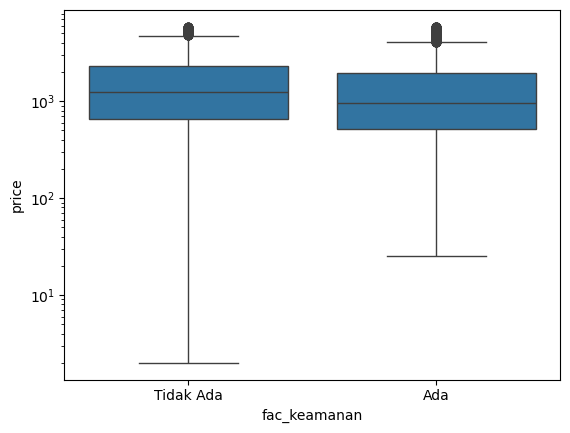

In [27]:
fac_price_ax = sns.boxplot(data=df_facilities_wide, x="fac_keamanan", y="price", formatter=formatter_one_zero)
plt.yscale("log")

In [28]:
pointbiser_corr(df_facilities_wide, "fac").round(4).style.map(formatter_pvalue, subset=["pvalue"])

/home/fahmi/.mambaforge/envs/scraping/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,variable,method,r,pvalue
0,fac_ac,pointbiser,0.102300,0.000000
1,fac_air_pam,pointbiser,-0.011900,0.107900
2,fac_air_tanah,pointbiser,-0.010500,0.156400
3,fac_aula,pointbiser,0.019800,0.007500
4,fac_balcony,pointbiser,0.003600,0.627100
5,fac_canopy,pointbiser,-0.001900,0.794200
6,fac_carport,pointbiser,0.070300,0.000000
7,fac_dapur,pointbiser,0.162500,0.000000
8,fac_dishwasher,pointbiser,-0.001600,0.833200
9,fac_floorboards,pointbiser,0.008000,0.280200


## L1: House Material

In [29]:
df_material.head()

,material,reference_id
0,bata_merah,hos7134732
1,bata_merah,hos7260502
2,bata_merah,hos7260680
3,bata_merah,hos7582047
4,bata_hebel,hos7682801


In [30]:
df_material["material"].unique()

array(['bata_merah', 'bata_hebel', 'beton', 'batako'], dtype=object)

In [31]:
df_material_wide = pd.crosstab(df_material["reference_id"], df_material["material"]).reset_index().add_prefix("mat_")
df_material_wide = df_houses.merge(df_material_wide, left_on="id", right_on="mat_reference_id", how="left")
df_material_wide = df_material_wide.drop(columns=["mat_reference_id", "id", "last_modified_at"])
df_material_wide = df_material_wide.fillna(0)
df_material_wide.head()

,price,installment,district,date,mat_bata_hebel,mat_bata_merah,mat_batako,mat_beton
0,3300.0,14.0,Puncak,2024-01-18,0.0,0.0,0.0,0.0
1,850.0,3.0,Cipanas,2023-09-12,0.0,1.0,0.0,0.0
2,1000.0,4.0,Cileungsi,2023-08-14,0.0,0.0,0.0,0.0
3,2500.0,11.0,Caringin,2023-09-24,0.0,0.0,0.0,0.0
4,3000.0,13.0,Kranggan,2023-11-29,0.0,0.0,0.0,0.0


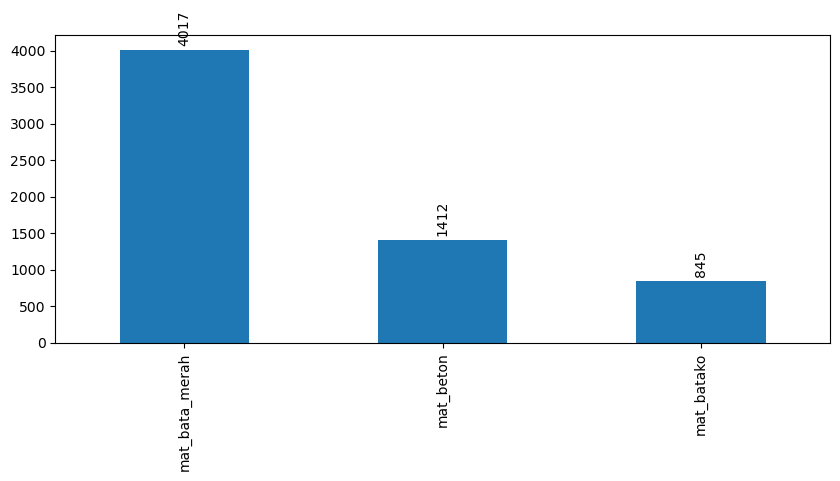

In [32]:
plt.figure(figsize=(10, 4))
count_ax = df_material_wide.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
count_ax.bar_label(count_ax.containers[0], padding=3, rotation=90)
plt.show()

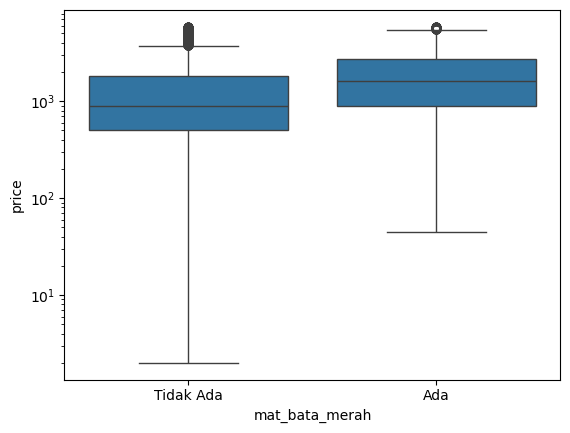

In [33]:
price_ax = sns.boxplot(data=df_material_wide, x="mat_bata_merah", y="price", formatter=formatter_one_zero)
plt.yscale("log")

In [34]:
pointbiser_corr(df_material_wide, "mat").round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,mat_bata_hebel,pointbiser,-0.280300,0.000000
1,mat_bata_merah,pointbiser,0.189000,0.000000
2,mat_batako,pointbiser,-0.040100,0.000000
3,mat_beton,pointbiser,0.046500,0.000000


## L1: Floor Material

In [35]:
df_floor_material.head()

,material,reference_id
0,keramik,hos7134732
1,granit,hos7260502
2,keramik,hos7260680
3,keramik,hos7657748
4,granit,hos7682801


In [36]:
df_floor_material["material"].unique()

array(['keramik', 'granit', 'marmer', 'ubin', 'vinyl'], dtype=object)

In [37]:
df_floor_wide = pd.crosstab(df_floor_material["reference_id"], df_floor_material["material"]).reset_index().add_prefix("mat_")
df_floor_wide = df_houses.merge(df_floor_wide, left_on="id", right_on="mat_reference_id", how="left")
df_floor_wide = df_floor_wide.drop(columns=["mat_reference_id", "id", "last_modified_at"])
df_floor_wide = df_floor_wide.fillna(0)
df_floor_wide.head()

,price,installment,district,date,mat_granit,mat_keramik,mat_marmer,mat_ubin,mat_vinyl
0,3300.0,14.0,Puncak,2024-01-18,0.0,0.0,0.0,0.0,0.0
1,850.0,3.0,Cipanas,2023-09-12,0.0,1.0,0.0,0.0,0.0
2,1000.0,4.0,Cileungsi,2023-08-14,0.0,0.0,0.0,0.0,0.0
3,2500.0,11.0,Caringin,2023-09-24,0.0,0.0,0.0,0.0,0.0
4,3000.0,13.0,Kranggan,2023-11-29,0.0,0.0,0.0,0.0,0.0


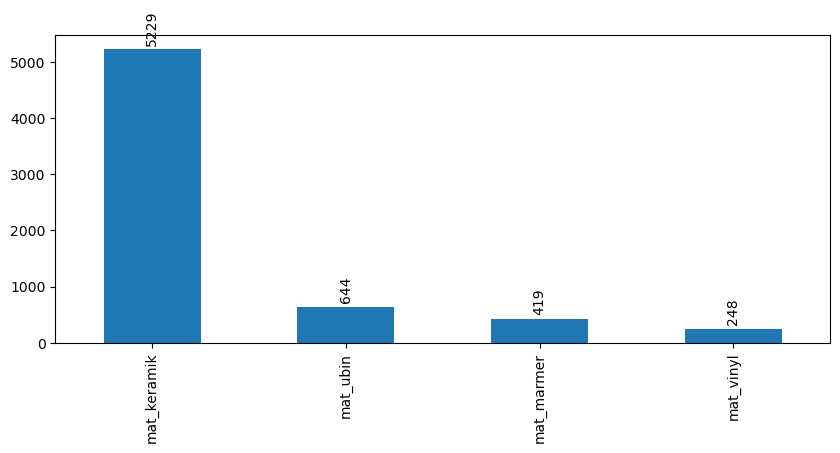

In [38]:
plt.figure(figsize=(10, 4))
count_ax = df_floor_wide.iloc[:, 5:].sum().sort_values(ascending=False).plot.bar()
count_ax.bar_label(count_ax.containers[0], padding=3, rotation=90)
plt.show()

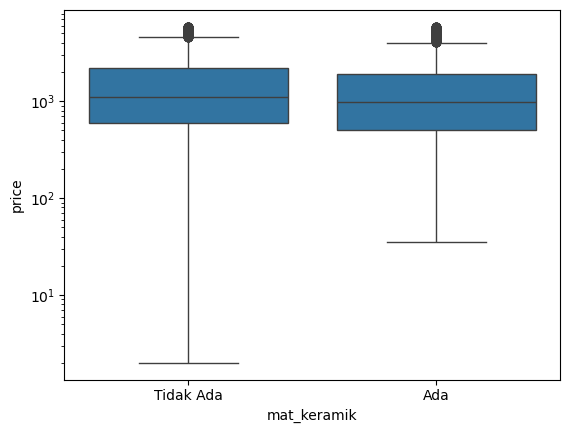

In [39]:
price_ax = sns.boxplot(data=df_floor_wide, x="mat_keramik", y="price", formatter=formatter_one_zero)
plt.yscale("log")

In [40]:
pointbiser_corr(df_floor_wide, "mat").round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,mat_granit,pointbiser,-0.106900,0.000000
1,mat_keramik,pointbiser,-0.056800,0.000000
2,mat_marmer,pointbiser,0.096800,0.000000
3,mat_ubin,pointbiser,-0.012000,0.104600
4,mat_vinyl,pointbiser,0.072200,0.000000


## L1: Specs

In [41]:
df_specs.head()

,kamar_tidur,kamar_mandi,sertifikat,kamar_pembantu,kamar_mandi_pembantu,jumlah_lantai,tahun_dibangun,dapur,garasi,pemandangan,...,luas_tanah,luas_bangunan,daya_listrik,lebar_jalan,kondisi_properti,kondisi_perabotan,ruang_makan,ruang_tamu,terjangkau_internet,hook
0,3.0,3.0,SHM - Sertifikat Hak Milik,1.0,1.0,1.0,1000.0,NaN,NaN,None,...,300.0,180.0,2200.0,NaN,furnished,None,None,None,None,None
1,4.0,3.0,SHM - Sertifikat Hak Milik,4.0,1.0,1.0,2016.0,1.0,4.0,Pegunungan,...,385.0,270.0,2200.0,2.0,furnished,semi furnished,False,False,True,False
2,3.0,2.0,SHM - Sertifikat Hak Milik,NaN,NaN,2.0,2020.0,NaN,1.0,None,...,68.0,72.0,2200.0,NaN,furnished,None,None,None,None,None
3,3.0,3.0,SHM - Sertifikat Hak Milik,2.0,1.0,1.0,2013.0,NaN,3.0,None,...,1200.0,450.0,13200.0,NaN,furnished,furnished,None,None,None,None
4,4.0,4.0,"Lainnya (PPJB,Girik,Adat,dll)",NaN,NaN,NaN,NaN,NaN,NaN,None,...,300.0,400.0,0.0,NaN,None,None,None,None,None,None


In [42]:
df_specs_wide = df_houses.merge(df_specs, left_on="id", right_on="reference_id", how="left")
df_specs_wide = df_specs_wide.drop(columns=["reference_id", "id", "last_modified_at", "date"])
df_specs_wide.head()

,price,installment,district,kamar_tidur,kamar_mandi,sertifikat,kamar_pembantu,kamar_mandi_pembantu,jumlah_lantai,tahun_dibangun,...,luas_tanah,luas_bangunan,daya_listrik,lebar_jalan,kondisi_properti,kondisi_perabotan,ruang_makan,ruang_tamu,terjangkau_internet,hook
0,3300.0,14.0,Puncak,3.0,3.0,SHM - Sertifikat Hak Milik,1.0,1.0,1.0,1000.0,...,300.0,180.0,2200.0,NaN,furnished,None,None,None,None,None
1,850.0,3.0,Cipanas,4.0,3.0,SHM - Sertifikat Hak Milik,4.0,1.0,1.0,2016.0,...,385.0,270.0,2200.0,2.0,furnished,semi furnished,False,False,True,False
2,1000.0,4.0,Cileungsi,3.0,2.0,SHM - Sertifikat Hak Milik,NaN,NaN,2.0,2020.0,...,68.0,72.0,2200.0,NaN,furnished,None,None,None,None,None
3,2500.0,11.0,Caringin,3.0,3.0,SHM - Sertifikat Hak Milik,2.0,1.0,1.0,2013.0,...,1200.0,450.0,13200.0,NaN,furnished,furnished,None,None,None,None
4,3000.0,13.0,Kranggan,4.0,4.0,"Lainnya (PPJB,Girik,Adat,dll)",NaN,NaN,NaN,NaN,...,300.0,400.0,0.0,NaN,None,None,None,None,None,None


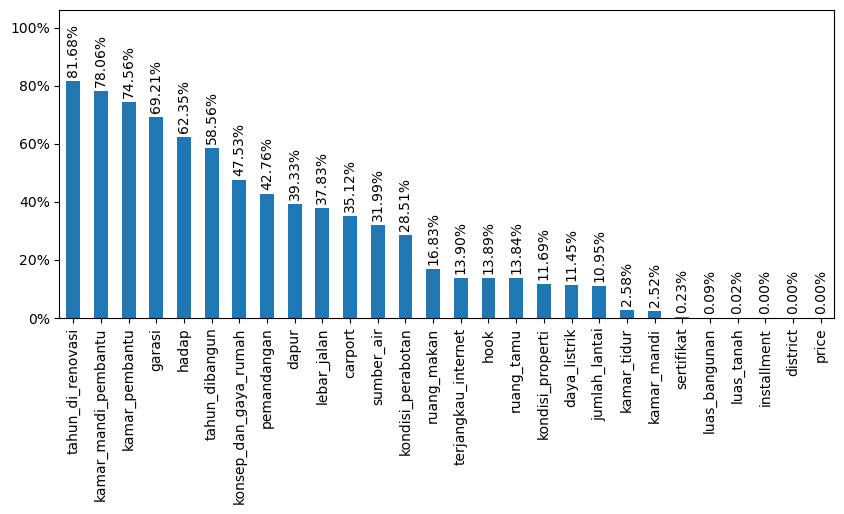

In [43]:
plt.figure(figsize=(10, 4))
count_ax = (df_specs_wide.isna().sum() / len(df_specs_wide)).sort_values(ascending=False).plot.bar()
count_ax.bar_label(count_ax.containers[0], padding=3, rotation=90, fmt='{:.2%}')
count_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
count_ax.margins(y=0.3)
plt.show()

In [44]:
df_specs_wide["sertifikat"].value_counts()

sertifikat
SHM - Sertifikat Hak Milik       14674
HGB - Hak Guna Bangunan           2637
Lainnya (PPJB,Girik,Adat,dll)      887
HP - Hak Pakai                       4
PPJB                                 1
Name: count, dtype: int64

In [45]:
# drop columns with too many missing values
df_specs_wide = df_specs_wide.drop(columns=["tahun_di_renovasi", "kamar_mandi_pembantu", "kamar_pembantu", "garasi", "hadap", "tahun_dibangun"])

# fill missing values
fill_rules = [
    {"col": "konsep_dan_gaya_rumah", "method": "mode"},
    {"col": "pemandangan", "method": "mode"},
    {"col": "dapur", "method": "constant", "value": 1},
    {"col": "lebar_jalan", "method": "constant", "value": 0},
    {"col": "carport", "method": "constant", "value": 0},
    {"col": "sumber_air", "method": "mode"},
    {"col": "kondisi_perabotan", "method": "constant", "value": "unfurnished"},
    {"col": "ruang_makan", "method": "constant", "value": False},
    {"col": "terjangkau_internet", "method": "constant", "value": False},
    {"col": "hook", "method": "constant", "value": False},
    {"col": "ruang_tamu", "method": "constant", "value": False},
    {"col": "kondisi_properti", "method": "constant", "value": "unfurnished"},
    {"col": "daya_listrik", "method": "mode"},
    {"col": "jumlah_lantai", "method": "constant", "value": 1},
    {"col": "kamar_tidur", "method": "constant", "value": 1},
    {"col": "kamar_mandi", "method": "constant", "value": 1},
    {"col": "sertifikat", "method": "mode"},
    {"col": "luas_bangunan", "method": "mean"},
    {"col": "luas_tanah", "method": "mean"},
    {"col": "price", "method": "median"},
]

for rule in fill_rules:
    if rule["method"] == "mode":
        df_specs_wide[rule["col"]] = df_specs_wide[rule["col"]].fillna(df_specs_wide[rule["col"]].mode()[0])
    elif rule["method"] == "mean":
        df_specs_wide[rule["col"]] = df_specs_wide[rule["col"]].fillna(df_specs_wide[rule["col"]].mean())
    elif rule["method"] == "median":
        df_specs_wide[rule["col"]] = df_specs_wide[rule["col"]].fillna(df_specs_wide[rule["col"]].median())
    elif rule["method"] == "constant":
        df_specs_wide[rule["col"]] = df_specs_wide[rule["col"]].fillna(rule["value"])

In [46]:
# remove outlier
df_specs_wide = df_specs_wide[df_specs_wide["kamar_tidur"] < 100]
df_specs_wide = df_specs_wide[df_specs_wide["luas_tanah"] < 20000]

<Axes: xlabel='kamar_tidur', ylabel='price'>

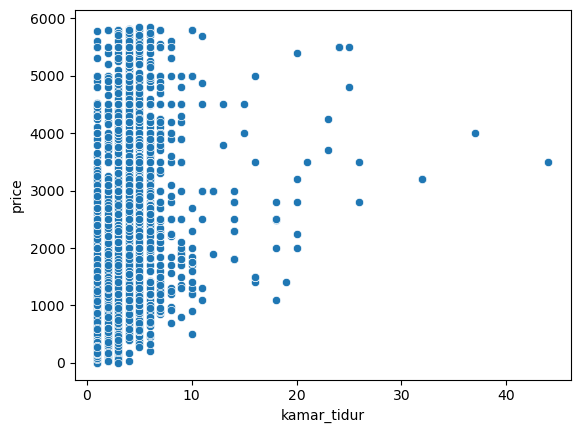

In [47]:
sns.scatterplot(df_specs_wide, x="kamar_tidur", y="price")

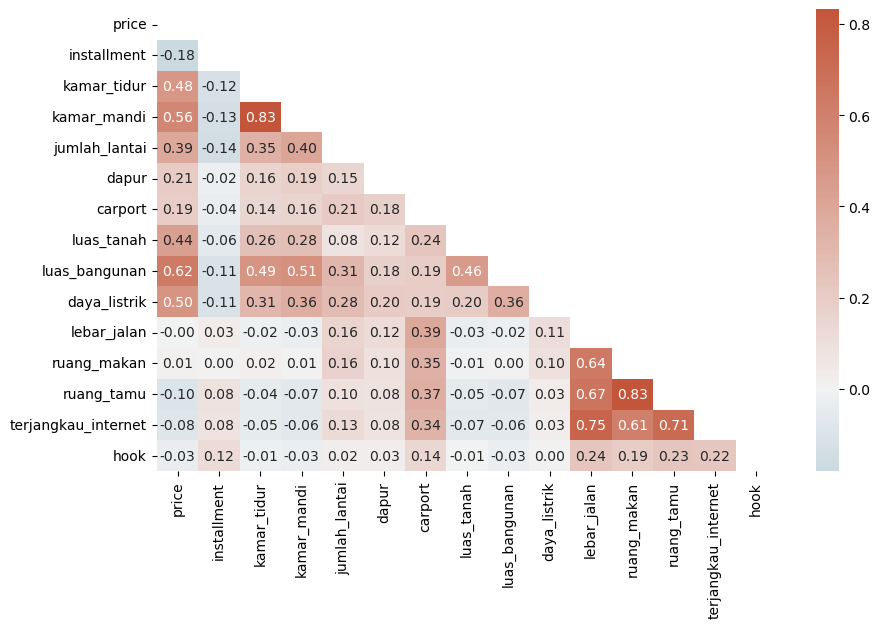

In [48]:
plot_corr(df_specs_wide)

In [49]:
pearsonr_corr(df_specs_wide).round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,installment,pearson,-0.180700,0.000000
1,kamar_tidur,pearson,0.480800,0.000000
2,kamar_mandi,pearson,0.562800,0.000000
3,jumlah_lantai,pearson,0.389900,0.000000
4,dapur,pearson,0.207200,0.000000
5,carport,pearson,0.194000,0.000000
6,luas_tanah,pearson,0.440100,0.000000
7,luas_bangunan,pearson,0.623000,0.000000
8,daya_listrik,pearson,0.498900,0.000000
9,lebar_jalan,pearson,-0.002700,0.713900


In [50]:
pointbiser_corr(df_specs_wide, "tamu").round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,ruang_tamu,pointbiser,-0.098200,0.000000


In [51]:
pointbiser_corr(df_specs_wide, "internet").round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,terjangkau_internet,pointbiser,-0.080800,0.000000


In [52]:
pointbiser_corr(df_specs_wide, "hook").round(4).style.map(formatter_pvalue, subset=["pvalue"])

,variable,method,r,pvalue
0,hook,pointbiser,-0.033300,0.000000


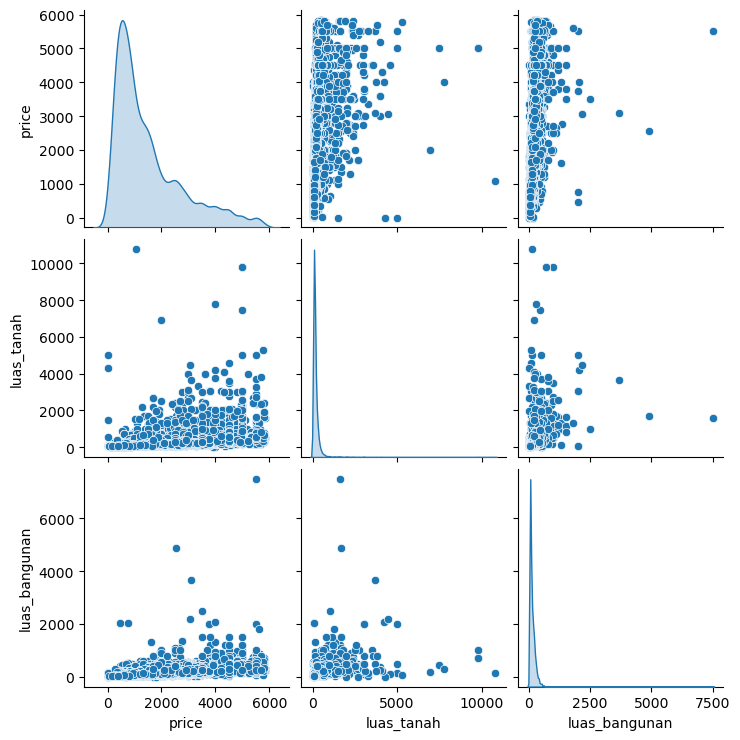

In [53]:
sns.pairplot(df_specs_wide, diag_kind='kde', vars=["price", "luas_tanah", "luas_bangunan"])

In [54]:
with pd.option_context('display.float_format', '{:.4f}'.format):
  display(sms.descriptivestats.describe(df_specs_wide))

,price,installment,kamar_tidur,kamar_mandi,jumlah_lantai,dapur,carport,luas_tanah,luas_bangunan,daya_listrik,lebar_jalan
nobs,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000,18242.0000
missing,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
mean,1504.6013,38.4571,2.9286,2.0980,1.4280,1.0271,0.8677,181.6026,128.3796,2101.3293,1.2715
std_err,9.4106,1.1441,0.0111,0.0107,0.0041,0.0013,0.0071,2.4283,1.0338,10.3990,0.0081
upper_ci,1523.0458,40.6996,2.9503,2.1190,1.4360,1.0296,0.8816,186.3620,130.4057,2121.7110,1.2873
lower_ci,1486.1568,36.2147,2.9069,2.0769,1.4200,1.0245,0.8538,176.8432,126.3534,2080.9477,1.2557
std,1271.0263,154.5310,1.4956,1.4494,0.5526,0.1762,0.9583,327.9771,139.6236,1404.5177,1.0900
iqr,1460.0000,9.0000,1.0000,2.0000,1.0000,0.0000,1.0000,113.0000,122.0000,900.0000,2.0000
iqr_normal,1082.2996,6.6717,0.7413,1.4826,0.7413,0.0000,0.7413,83.7670,90.4387,667.1710,1.4826
mad,994.2491,60.8908,0.9091,0.9389,0.5086,0.0528,0.6092,127.1046,82.6649,856.8179,1.0009


## L1: Agent Company

In [55]:
df_agent_company.head()

,name,url,reference_id
0,NINE PROPERTI,https://www.rumah123.com/agen-properti/nine-pr...,hos7134669
1,LJ HOOKER,https://www.rumah123.com/agen-properti/lj-hook...,hos7134732
2,CENTURY21,https://www.rumah123.com/agen-properti/century...,hos7134830
3,RAY WHITE,https://www.rumah123.com/agen-properti/ray-whi...,hos7135635
4,RAY WHITE,https://www.rumah123.com/agen-properti/ray-whi...,hos7136060


In [56]:
df_agent_wide = df_houses.merge(df_agent_company, left_on="id", right_on="reference_id", how="left")
df_agent_wide = df_agent_wide.drop(columns=["reference_id", "id", "last_modified_at", "date", "url"])
df_agent_wide.head()

,price,installment,district,name
0,3300.0,14.0,Puncak,NINE PROPERTI
1,850.0,3.0,Cipanas,LJ HOOKER
2,1000.0,4.0,Cileungsi,CENTURY21
3,2500.0,11.0,Caringin,RAY WHITE
4,3000.0,13.0,Kranggan,RAY WHITE


In [57]:
df_price = df_agent_wide.pivot_table(index="name", values="price", aggfunc=["count", "mean", "median", "std", "min", "max"], fill_value=0)
df_price.sort_values(("count", "price"), ascending=False).head()

,count,mean,median,std,min,max
,price,price,price,price,price,price
name,,,,,,
PASHOUSES.ID,1283,1116.453624,960.0,554.966713,380.0,3750.0
CENTURY21,1265,1989.978656,1550.0,1388.933269,4.0,5820.0
ERA,852,1701.073944,1300.0,1227.483755,142.0,5800.0
BRIGHTON,846,1455.174941,1100.0,1107.124796,95.0,5700.0
RAY WHITE,570,1800.385965,1400.0,1286.866232,2.5,5800.0


In [58]:
df_price = df_agent_wide.pivot_table(index=["district", "name"], values="price", aggfunc=["count", "mean", "median", "std", "min", "max"], fill_value=0)
df_price.sort_values(("count", "price"), ascending=False).head()

count         mean  median          std  \
                                   price        price   price        price   
district    name                                                             
Sentul City NAS GLOBAL PROPERTI      446  2730.479821  2600.0  1415.607864   
            MITRA PROPERTI           373  2633.176944  2500.0  1467.394929   
            DEALS PROPERTI           306  2404.330065  2250.0  1382.204094   
Kota Wisata TRUSTY PROPERTI          246  2299.430894  2000.0  1013.909227   
            COIN REAL ESTATE AGENT   201  2422.512438  2200.0   965.760338   

                                       min     max  
                                     price   price  
district    name                                    
Sentul City NAS GLOBAL PROPERTI      465.0  5800.0  
            MITRA PROPERTI           600.0  5800.0  
            DEALS PROPERTI           410.0  5500.0  
Kota Wisata TRUSTY PROPERTI         1000.0  5500.0  
            COIN REAL ESTATE AGENT   970.0  5800.0